In [1]:
"""
Prepared by Murat BRONZ
for Mineur Drone Lecture
ENAC 2023

Reference code used :
=====================
Grid based Dijkstra planning
author: AtsushiSakai(@Atsushi_twi)

A* grid planning
author: Atsushi Sakai(@Atsushi_twi)
        Nikos Kanargias (nkana@tee.gr)
See Wikipedia article (https://en.wikipedia.org/wiki/A*_search_algorithm)

D* grid planning
author: Nirnay Roy
See Wikipedia article (https://en.wikipedia.org/wiki/D*)

Path planning Sample Code with Randomized Rapidly-Exploring Random Trees (RRT)
author: Atsushi Sakai(@Atsushi_twi)

"""
from sys import maxsize
import matplotlib
import matplotlib.pyplot as plt
import math
import random
import numpy as np

show_animation = False

In [2]:
class State:

    def __init__(self, x, y):
        self.x = x
        self.y = y
        self.parent = None
        self.state = "."
        self.t = "new"  # tag for state
        self.h = 0
        self.k = 0

    def cost(self, state):
        if self.state == "#" or state.state == "#":
            return maxsize

        return math.sqrt(math.pow((self.x - state.x), 2) +
                         math.pow((self.y - state.y), 2))

    def set_state(self, state):
        """
        .: new
        #: obstacle
        e: oparent of current state
        *: closed state
        s: current state
        """
        if state not in ["s", ".", "#", "e", "*"]:
            return
        self.state = state

class Map:

    def __init__(self, row, col):
        self.row = row
        self.col = col
        self.map = self.init_map()
        self.obstacles = []

    def init_map(self):
        map_list = []
        for i in range(self.row):
            tmp = []
            for j in range(self.col):
                tmp.append(State(i, j))
            map_list.append(tmp)
        return map_list

    def get_neighbors(self, state):
        state_list = []
        for i in [-1, 0, 1]:
            for j in [-1, 0, 1]:
                if i == 0 and j == 0:
                    continue
                if state.x + i < 0 or state.x + i >= self.row:
                    continue
                if state.y + j < 0 or state.y + j >= self.col:
                    continue
                state_list.append(self.map[state.x + i][state.y + j])
        return state_list

    def set_obstacle(self, point_list):
        for x, y in point_list:
            if x < 0 or x >= self.row or y < 0 or y >= self.col:
                continue

            self.map[x][y].set_state("#")
            self.obstacles.append([x,y])

class Node:
    """
    Generic Node for Dijkstra-RRT-
    """

    def __init__(self, x, y, cost=None, parent_index=None):
        self.x = x  # index of grid
        self.y = y  # index of grid
        self.cost = cost
        self.parent_index = parent_index  # index of previous Node
        self.path_x = []
        self.path_y = []
        self.parent = None

    def __str__(self):
        return str(self.x) + "," + str(self.y) + "," + str(
            self.cost) + "," + str(self.parent_index)

class AreaBounds:

    def __init__(self, area):
        self.xmin = float(area[0])
        self.xmax = float(area[1])
        self.ymin = float(area[2])
        self.ymax = float(area[3])

In [3]:

class Dijkstra:

    def __init__(self, map, resolution=1, robot_radius=1):
        """
        Initialize map for a star planning

        ox: x position list of Obstacles [m]
        oy: y position list of Obstacles [m]
        resolution: grid resolution [m]
        rr: robot radius[m]
        """

        self.min_x = 0
        self.min_y = 0
        # self.max_x = None
        # self.max_y = None
        # self.x_width = None
        # self.y_width = None
        self.obstacle_map = None
        self.map = map
        self.x_width = self.map.col
        self.y_width = self.map.row
        self.max_x = self.x_width
        self.max_y = self.y_width

        self.resolution = resolution
        self.robot_radius = robot_radius
        # self.calc_obstacle_map(self.map)
        self.motion = self.get_motion_model()
        # print(self.map.map)

    def planning(self, start, end): #sx, sy, gx, gy):
        """
        dijkstra path search

        input:
            start : start.x : start x position [m]
                    start.y : start y position [m]
            end   : end.x : goal x position [m]
                    end.y : goal x position [m]

        output:
            rx: x position list of the final path
            ry: y position list of the final path
        """

        # start_node = Node(self.calc_xy_index(start.x, self.min_x),
        #                        self.calc_xy_index(start.y, self.min_y), 0.0, -1)
        # goal_node = Node(self.calc_xy_index(end.x, self.min_x),
        #                       self.calc_xy_index(end.y, self.min_y), 0.0, -1)

        start_node = Node(start.x, start.y, 0.0, -1)
        goal_node = Node(end.x, end.y, 0.0, -1)

        open_set, closed_set = dict(), dict()
        open_set[self.calc_index(start_node)] = start_node

        while True:
            c_id = min(open_set, key=lambda o: open_set[o].cost)
            current = open_set[c_id]

            # show graph
            if show_animation:  # pragma: no cover
                # plt.plot(self.calc_position(current.x, self.min_x),
                #          self.calc_position(current.y, self.min_y), "xc")
                plt.plot(current.x, current.y, "xc")
                # for stopping simulation with the esc key.
                plt.gcf().canvas.mpl_connect(
                    'key_release_event',
                    lambda event: [exit(0) if event.key == 'escape' else None])
                if len(closed_set.keys()) % 10 == 0:
                    plt.pause(0.001)

            if current.x == goal_node.x and current.y == goal_node.y:
                print("Find goal")
                goal_node.parent_index = current.parent_index
                goal_node.cost = current.cost
                break

            # Remove the item from the open set
            del open_set[c_id]

            # Add it to the closed set
            closed_set[c_id] = current

            # expand search grid based on motion model
            for move_x, move_y, move_cost in self.motion:
                node = Node(current.x + move_x,
                                 current.y + move_y,
                                 current.cost + move_cost, c_id)
                n_id = self.calc_index(node)

                if n_id in closed_set:
                    continue

                if not self.verify_node(node):
                    continue

                if n_id not in open_set:
                    open_set[n_id] = node  # Discover a new node
                else:
                    if open_set[n_id].cost >= node.cost:
                        # This path is the best until now. record it!
                        open_set[n_id] = node

        rx, ry = self.calc_final_path(goal_node, closed_set)

        return rx, ry

    def calc_final_path(self, goal_node, closed_set):
        # import pdb
        # generate final course
        # print("Innside !!!!")
        rx, ry = [self.calc_position(goal_node.x, self.min_x)], [
            self.calc_position(goal_node.y, self.min_y)]
        # pdb.set_trace()
        parent_index = goal_node.parent_index
        while parent_index != -1:
            n = closed_set[parent_index]
            rx.append(self.calc_position(n.x, self.min_x))
            ry.append(self.calc_position(n.y, self.min_y))
            parent_index = n.parent_index
        # pdb.set_trace()
        return rx, ry

    def calc_position(self, index, minp):
        pos = index * self.resolution + minp
        return pos

    def calc_xy_index(self, position, minp):
        return round((position - minp) / self.resolution)

    def calc_index(self, node):
        return (node.y - self.min_y) * self.x_width + (node.x - self.min_x)

    def verify_node(self, node):
        px = self.calc_position(node.x, self.min_x)
        py = self.calc_position(node.y, self.min_y)

        if px < self.min_x:
            return False
        if py < self.min_y:
            return False
        if px >= self.max_x:
            return False
        if py >= self.max_y:
            return False

        if self.map.map[node.x][node.y].state=="#":
            return False

        return True

    # def calc_obstacle_map(self, ox, oy):
    #     self.min_x = round(min(ox))
    #     self.min_y = round(min(oy))
    #     self.max_x = round(max(ox))
    #     self.max_y = round(max(oy))
    #     print("min_x:", self.min_x)
    #     print("min_y:", self.min_y)
    #     print("max_x:", self.max_x)
    #     print("max_y:", self.max_y)

    #     self.x_width = round((self.max_x - self.min_x) / self.resolution)
    #     self.y_width = round((self.max_y - self.min_y) / self.resolution)
    #     print("x_width:", self.x_width)
    #     print("y_width:", self.y_width)

    #     # obstacle map generation
    #     self.obstacle_map = [[False for _ in range(self.y_width)]
    #                          for _ in range(self.x_width)]
    #     for ix in range(self.x_width):
    #         x = self.calc_position(ix, self.min_x)
    #         for iy in range(self.y_width):
    #             y = self.calc_position(iy, self.min_y)
    #             for iox, ioy in zip(ox, oy):
    #                 d = math.hypot(iox - x, ioy - y)
    #                 if d <= self.robot_radius:
    #                     self.obstacle_map[ix][iy] = True
    #                     break

    @staticmethod
    def get_motion_model():
        # dx, dy, cost
        motion = [[1, 0, 1],
                  [0, 1, 1],
                  [-1, 0, 1],
                  [0, -1, 1],
                  [-1, -1, math.sqrt(2)],
                  [-1, 1, math.sqrt(2)],
                  [1, -1, math.sqrt(2)],
                  [1, 1, math.sqrt(2)]]

        return motion


In [4]:

class Dstar:
    def __init__(self, maps):
        self.map = maps
        self.open_list = set()

    def process_state(self):
        x = self.min_state()

        if x is None:
            return -1

        k_old = self.get_kmin()
        self.remove(x)

        if k_old < x.h:
            for y in self.map.get_neighbors(x):
                if y.h <= k_old and x.h > y.h + x.cost(y):
                    x.parent = y
                    x.h = y.h + x.cost(y)
        elif k_old == x.h:
            for y in self.map.get_neighbors(x):
                if y.t == "new" or y.parent == x and y.h != x.h + x.cost(y) \
                        or y.parent != x and y.h > x.h + x.cost(y):
                    y.parent = x
                    self.insert(y, x.h + x.cost(y))
        else:
            for y in self.map.get_neighbors(x):
                if y.t == "new" or y.parent == x and y.h != x.h + x.cost(y):
                    y.parent = x
                    self.insert(y, x.h + x.cost(y))
                else:
                    if y.parent != x and y.h > x.h + x.cost(y):
                        self.insert(y, x.h)
                    else:
                        if y.parent != x and x.h > y.h + x.cost(y) \
                                and y.t == "close" and y.h > k_old:
                            self.insert(y, y.h)
        return self.get_kmin()

    def min_state(self):
        if not self.open_list:
            return None
        min_state = min(self.open_list, key=lambda x: x.k)
        return min_state

    def get_kmin(self):
        if not self.open_list:
            return -1
        k_min = min([x.k for x in self.open_list])
        return k_min

    def insert(self, state, h_new):
        if state.t == "new":
            state.k = h_new
        elif state.t == "open":
            state.k = min(state.k, h_new)
        elif state.t == "close":
            state.k = min(state.h, h_new)
        state.h = h_new
        state.t = "open"
        self.open_list.add(state)

    def remove(self, state):
        if state.t == "open":
            state.t = "close"
        self.open_list.remove(state)

    def modify_cost(self, x):
        if x.t == "close":
            self.insert(x, x.parent.h + x.cost(x.parent))

    def run(self, start, end):

        rx = []
        ry = []

        self.insert(end, 0.0)

        while True:
            self.process_state()
            if start.t == "close":
                break

        start.set_state("s")
        s = start
        s = s.parent
        s.set_state("e")
        tmp = start

        while tmp != end:
            tmp.set_state("*")
            rx.append(tmp.x)
            ry.append(tmp.y)
            if show_animation:
                plt.plot(rx, ry, "-r")
                plt.pause(0.01)
            if tmp.parent.state == "#":
                self.modify(tmp)
                continue
            tmp = tmp.parent
        tmp.set_state("e")

        return rx, ry

    def modify(self, state):
        self.modify_cost(state)
        while True:
            k_min = self.process_state()
            if k_min >= state.h:
                break


In [5]:

class Astar:

    def __init__(self, map, resolution=1, robot_radius=1):
        """
        Initialize grid map for a star planning

        ox: x position list of Obstacles [m]
        oy: y position list of Obstacles [m]
        resolution: grid resolution [m]
        rr: robot radius[m]
        """
        self.min_x = 0
        self.min_y = 0
        # self.max_x = None
        # self.max_y = None
        # self.x_width = None
        # self.y_width = None
        self.obstacle_map = None
        self.map = map
        self.x_width = self.map.col
        self.y_width = self.map.row
        self.max_x = self.x_width
        self.max_y = self.y_width

        self.resolution = resolution
        self.robot_radius = robot_radius
        # self.calc_obstacle_map(self.map)
        self.motion = self.get_motion_model()

        # self.resolution = resolution
        self.rr = robot_radius
        # self.min_x, self.min_y = 0, 0
        # self.max_x, self.max_y = 0, 0
        # self.obstacle_map = None
        # self.x_width, self.y_width = 0, 0
        # self.motion = self.get_motion_model()
        # self.calc_obstacle_map(ox, oy)

    def planning(self, start, end): #sx, sy, gx, gy):
        """
        A star path search

        input:
            s_x: start x position [m]
            s_y: start y position [m]
            gx: goal x position [m]
            gy: goal y position [m]

        output:
            rx: x position list of the final path
            ry: y position list of the final path
        """

        # start_node = Node(self.calc_xy_index(sx, self.min_x),
        #                        self.calc_xy_index(sy, self.min_y), 0.0, -1)
        # goal_node = Node(self.calc_xy_index(gx, self.min_x),
        #                       self.calc_xy_index(gy, self.min_y), 0.0, -1)
        start_node = Node(start.x, start.y, 0.0, -1)
        goal_node = Node(end.x, end.y, 0.0, -1)

        open_set, closed_set = dict(), dict()
        open_set[self.calc_grid_index(start_node)] = start_node

        while True:
            if len(open_set) == 0:
                print("Open set is empty..")
                break

            c_id = min(
                open_set,
                key=lambda o: open_set[o].cost + self.calc_heuristic(goal_node,
                                                                     open_set[
                                                                         o]))
            current = open_set[c_id]

            # show graph
            if show_animation:  # pragma: no cover
                plt.plot(self.calc_grid_position(current.x, self.min_x),
                         self.calc_grid_position(current.y, self.min_y), "xc")
                # for stopping simulation with the esc key.
                plt.gcf().canvas.mpl_connect('key_release_event',
                                             lambda event: [exit(
                                                 0) if event.key == 'escape' else None])
                if len(closed_set.keys()) % 10 == 0:
                    plt.pause(0.001)

            if current.x == goal_node.x and current.y == goal_node.y:
                print("Find goal")
                goal_node.parent_index = current.parent_index
                goal_node.cost = current.cost
                break

            # Remove the item from the open set
            del open_set[c_id]

            # Add it to the closed set
            closed_set[c_id] = current

            # expand_grid search grid based on motion model
            for i, _ in enumerate(self.motion):
                node = Node(current.x + self.motion[i][0],
                                 current.y + self.motion[i][1],
                                 current.cost + self.motion[i][2], c_id)
                n_id = self.calc_grid_index(node)

                # If the node is not safe, do nothing
                if not self.verify_node(node):
                    continue

                if n_id in closed_set:
                    continue

                if n_id not in open_set:
                    open_set[n_id] = node  # discovered a new node
                else:
                    if open_set[n_id].cost > node.cost:
                        # This path is the best until now. record it
                        open_set[n_id] = node

        rx, ry = self.calc_final_path(goal_node, closed_set)

        return rx, ry

    def calc_final_path(self, goal_node, closed_set):
        # generate final course
        rx, ry = [self.calc_grid_position(goal_node.x, self.min_x)], [
            self.calc_grid_position(goal_node.y, self.min_y)]
        parent_index = goal_node.parent_index
        while parent_index != -1:
            n = closed_set[parent_index]
            rx.append(self.calc_grid_position(n.x, self.min_x))
            ry.append(self.calc_grid_position(n.y, self.min_y))
            parent_index = n.parent_index

        return rx, ry

    @staticmethod
    def calc_heuristic(n1, n2):
        w = 1.0  # weight of heuristic
        d = w * math.hypot(n1.x - n2.x, n1.y - n2.y)
        return d

    def calc_grid_position(self, index, min_position):
        """
        calc grid position

        :param index:
        :param min_position:
        :return:
        """
        pos = index * self.resolution + min_position
        return pos

    def calc_xy_index(self, position, min_pos):
        return round((position - min_pos) / self.resolution)

    def calc_grid_index(self, node):
        return (node.y - self.min_y) * self.x_width + (node.x - self.min_x)

    def verify_node(self, node):
        px = self.calc_grid_position(node.x, self.min_x)
        py = self.calc_grid_position(node.y, self.min_y)

        if px < self.min_x:
            return False
        elif py < self.min_y:
            return False
        elif px >= self.max_x:
            return False
        elif py >= self.max_y:
            return False

        # collision check
        # if self.obstacle_map[node.x][node.y]:
        #     return False
        if self.map.map[node.x][node.y].state=="#":
            return False

        return True

    def calc_obstacle_map(self, ox, oy):

        self.min_x = round(min(ox))
        self.min_y = round(min(oy))
        self.max_x = round(max(ox))
        self.max_y = round(max(oy))
        print("min_x:", self.min_x)
        print("min_y:", self.min_y)
        print("max_x:", self.max_x)
        print("max_y:", self.max_y)

        self.x_width = round((self.max_x - self.min_x) / self.resolution)
        self.y_width = round((self.max_y - self.min_y) / self.resolution)
        print("x_width:", self.x_width)
        print("y_width:", self.y_width)

        # obstacle map generation
        self.obstacle_map = [[False for _ in range(self.y_width)]
                             for _ in range(self.x_width)]
        for ix in range(self.x_width):
            x = self.calc_grid_position(ix, self.min_x)
            for iy in range(self.y_width):
                y = self.calc_grid_position(iy, self.min_y)
                for iox, ioy in zip(ox, oy):
                    d = math.hypot(iox - x, ioy - y)
                    if d <= self.rr:
                        self.obstacle_map[ix][iy] = True
                        break

    @staticmethod
    def get_motion_model():
        # dx, dy, cost
        motion = [[1, 0, 1],
                  [0, 1, 1],
                  [-1, 0, 1],
                  [0, -1, 1],
                  [-1, -1, math.sqrt(2)],
                  [-1, 1, math.sqrt(2)],
                  [1, -1, math.sqrt(2)],
                  [1, 1, math.sqrt(2)]]

        return motion


In [6]:

class RRT:
    """
    Class for RRT planning
    """
    def __init__(self,
                 map,
                 expand_dis=3.0,
                 path_resolution=0.5,
                 goal_sample_rate=5,
                 max_iter=500,
                 play_area=None,
                 robot_radius=0.0,
                 ):
        """
        Setting Parameter

        start:Start Position [x,y]
        goal:Goal Position [x,y]
        obstacleList:obstacle Positions [[x,y,size],...]
        randArea:Random Sampling Area [min,max]
        play_area:stay inside this area [xmin,xmax,ymin,ymax]
        robot_radius: robot body modeled as circle with given radius

        """
        self.map = map
        self.min_rand = 0
        self.max_rand = max(map.row, map.col)
        if play_area is not None:
            self.play_area = AreaBounds(play_area)
        else:
            self.play_area = None
        self.expand_dis = expand_dis
        self.path_resolution = path_resolution
        self.goal_sample_rate = goal_sample_rate
        self.max_iter = max_iter
        # self.obstacle_list = obstacle_list
        self.node_list = []
        self.robot_radius = robot_radius

    def planning(self, start, end, animation=True):
        """
        rrt path planning

        animation: flag for animation on or off
        """
        self.start = Node(start.x, start.y)
        self.end = Node(end.x, end.y)
        self.node_list = [self.start]
        for i in range(self.max_iter):
            rnd_node = self.get_random_node()
            nearest_ind = self.get_nearest_node_index(self.node_list, rnd_node)
            nearest_node = self.node_list[nearest_ind]

            new_node = self.steer(nearest_node, rnd_node, self.expand_dis)

            if self.check_if_outside_play_area(new_node, self.play_area) and \
               self.check_collision(
                   new_node, self.map.obstacles, self.robot_radius):
                self.node_list.append(new_node)

            if animation and i % 5 == 0:
                self.draw_graph(rnd_node)

            if self.calc_dist_to_goal(self.node_list[-1].x,
                                      self.node_list[-1].y) <= self.expand_dis:
                final_node = self.steer(self.node_list[-1], self.end,
                                        self.expand_dis)
                if self.check_collision(
                        final_node, self.map.obstacles, self.robot_radius):
                    return self.generate_final_course(len(self.node_list) - 1)

            if animation and i % 5:
                self.draw_graph(rnd_node)

        return None  # cannot find path

    def steer(self, from_node, to_node, extend_length=float("inf")):

        new_node = Node(from_node.x, from_node.y)
        d, theta = self.calc_distance_and_angle(new_node, to_node)

        new_node.path_x = [new_node.x]
        new_node.path_y = [new_node.y]

        if extend_length > d:
            extend_length = d

        n_expand = math.floor(extend_length / self.path_resolution)

        for _ in range(n_expand):
            new_node.x += self.path_resolution * math.cos(theta)
            new_node.y += self.path_resolution * math.sin(theta)
            new_node.path_x.append(new_node.x)
            new_node.path_y.append(new_node.y)

        d, _ = self.calc_distance_and_angle(new_node, to_node)
        if d <= self.path_resolution:
            new_node.path_x.append(to_node.x)
            new_node.path_y.append(to_node.y)
            new_node.x = to_node.x
            new_node.y = to_node.y

        new_node.parent = from_node

        return new_node

    def generate_final_course(self, goal_ind):
        path = [[self.end.x, self.end.y]]
        node = self.node_list[goal_ind]
        while node.parent is not None:
            path.append([node.x, node.y])
            node = node.parent
        path.append([node.x, node.y])

        return path

    def calc_dist_to_goal(self, x, y):
        dx = x - self.end.x
        dy = y - self.end.y
        return math.hypot(dx, dy)

    def get_random_node(self):
        if random.randint(0, 100) > self.goal_sample_rate:
            rnd = Node(
                random.uniform(self.min_rand, self.max_rand),
                random.uniform(self.min_rand, self.max_rand))
        else:  # goal point sampling
            rnd = Node(self.end.x, self.end.y)
        return rnd

    def draw_graph(self, rnd=None):
        plt.clf()
        # for stopping simulation with the esc key.
        plt.gcf().canvas.mpl_connect(
            'key_release_event',
            lambda event: [exit(0) if event.key == 'escape' else None])
        if rnd is not None:
            plt.plot(rnd.x, rnd.y, "^k")
            if self.robot_radius > 0.0:
                self.plot_circle(rnd.x, rnd.y, self.robot_radius, '-r')
        for node in self.node_list:
            if node.parent:
                plt.plot(node.path_x, node.path_y, "-g")

        # for (ox, oy, size) in self.obstacle_list:
        #     self.plot_circle(ox, oy, size)

        for [ox,oy] in self.map.obstacles:
            plt.plot(ox,oy,".k")

        if self.play_area is not None:
            plt.plot([self.play_area.xmin, self.play_area.xmax,
                      self.play_area.xmax, self.play_area.xmin,
                      self.play_area.xmin],
                     [self.play_area.ymin, self.play_area.ymin,
                      self.play_area.ymax, self.play_area.ymax,
                      self.play_area.ymin],
                     "-k")

        plt.plot(self.start.x, self.start.y, "xr")
        plt.plot(self.end.x, self.end.y, "xr")
        plt.axis("equal")
        # plt.axis([-2, 15, -2, 15])
        plt.grid(True)
        plt.pause(0.01)

    @staticmethod
    def plot_circle(x, y, size, color="-b"):  # pragma: no cover
        deg = list(range(0, 360, 5))
        deg.append(0)
        xl = [x + size * math.cos(np.deg2rad(d)) for d in deg]
        yl = [y + size * math.sin(np.deg2rad(d)) for d in deg]
        # plt.plot(xl, yl, color)
        circle = matplotlib.patches.Circle((x,y),size, color='blue', alpha=0.6)
        fig = plt.gcf()
        ax = fig.gca()
        ax.add_patch(circle)

    @staticmethod
    def get_nearest_node_index(node_list, rnd_node):
        dlist = [(node.x - rnd_node.x)**2 + (node.y - rnd_node.y)**2
                 for node in node_list]
        minind = dlist.index(min(dlist))

        return minind

    @staticmethod
    def check_if_outside_play_area(node, play_area):

        if play_area is None:
            return True  # no play_area was defined, every pos should be ok

        if node.x < play_area.xmin or node.x > play_area.xmax or \
           node.y < play_area.ymin or node.y > play_area.ymax:
            return False  # outside - bad
        else:
            return True  # inside - ok

    @staticmethod
    def check_collision(node, obstacleList, robot_radius):

        if node is None:
            return False

        for [ox, oy] in obstacleList:
            dx_list = [ox - x for x in node.path_x]
            dy_list = [oy - y for y in node.path_y]
            d_list = [dx * dx + dy * dy for (dx, dy) in zip(dx_list, dy_list)]

            if min(d_list) <= (0.5+robot_radius)**2: # FIXME hardcoded 0.5m
                return False  # collision
            
        # for (ox, oy, size) in obstacleList:
        #     dx_list = [ox - x for x in node.path_x]
        #     dy_list = [oy - y for y in node.path_y]
        #     d_list = [dx * dx + dy * dy for (dx, dy) in zip(dx_list, dy_list)]

        #     if min(d_list) <= (size+robot_radius)**2:
        #         return False  # collision

        return True  # safe

    @staticmethod
    def calc_distance_and_angle(from_node, to_node):
        dx = to_node.x - from_node.x
        dy = to_node.y - from_node.y
        d = math.hypot(dx, dy)
        theta = math.atan2(dy, dx)
        return d, theta


In [7]:
def generate_map():
    ox, oy = [], []
    # Generate the environment Frame (outside contours...)
    for i in range(0, 70):
        ox.append(i)
        oy.append(0)
    for i in range(0, 70):
        ox.append(70)
        oy.append(i)
    for i in range(0, 71):
        ox.append(i)
        oy.append(70)
    for i in range(0, 71):
        ox.append(0)
        oy.append(i)
    # Add inner separator walls (Optional)
    for i in range(0, 30):
        ox.append(20)
        oy.append(i)
    for i in range(0, 30):
        ox.append(45)
        oy.append(70 - i)
    
    # Add individual obstacles (Optional)
    ob_list = [
        (10, 10),
        (20, 20),
        (30, 30),
        (40, 40),
        (50, 50),
        (60, 60) ]

    # Add random points (Optional)
    for i in range(0, 10):
        ob_list.append((random.randint(0, 70), random.randint(0, 70)))
    # Finally add those points into the ox,oy lists
    for (x,y) in ob_list:
        for i in range(0, 5):
            ox.append(x+i)
            oy.append(y)
    return ox, oy

In [10]:
def main(start=[6,6], end=[55,60], method="dijkstra", show_animation=show_animation):
    # Generate the Map
    m = Map(71, 71)
    ox, oy = generate_map() # FIXME send the map as a parameter for size...

    # print([(i, j) for i, j in zip(ox, oy)])
    m.set_obstacle([(i, j) for i, j in zip(ox, oy)])

    # if show_animation:
    plt.plot(ox, oy, ".k")
    plt.plot(start[0], start[1], "og")
    plt.plot(end[0], end[1], "xb")
    plt.axis("equal")

    start = m.map[start[0]][start[1]]
    end = m.map[end[0]][end[1]]

    # Choose your method :
    #=====================
    print(method)
    match method:
        case "dijkstra":
            # DIJKSTRA
            dijkstra = Dijkstra(m, resolution=1, robot_radius=1)
            rx, ry = dijkstra.planning(start, end)
        case "astar":
            # A-Star
            a_star = Astar(m, resolution=1, robot_radius=1)
            rx, ry = a_star.planning(start, end)
        case "dstar":
            # D-Star
            dstar = Dstar(m)
            rx, ry = dstar.run(start, end)
        case "rrt":
            # RRT
            rrt = RRT(m,
                    expand_dis=5.,
                    path_resolution=1.0,
                    max_iter=1000, 
                    robot_radius=1)
            path = rrt.planning(start, end, animation=show_animation)
            rx = [x for (x,y) in path]
            ry = [y for (x,y) in path]
        case _:
            print("No method selected")
            return
    #=======================

    # if show_animation:
    plt.plot(rx, ry, "-r")
    plt.pause(0.01) # The final trajectory disapears without this !
    plt.show()

In [ ]:
# If you place the code in an external file...
if __name__ == '__main__':
    start = [6, 6]
    end = [55, 60]
    main(start, end, method="rrt") # dijkstra, astar, dstar, rrt

rrt


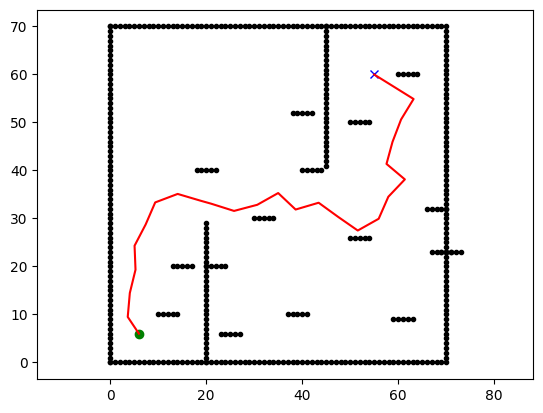

In [12]:
start = [6, 6]
end = [55, 60]
main(start, end, method="rrt", show_animation=False) # dijkstra, astar, dstar, rrt